# 分類方法による違いを確認する

1. ２クラスのデータを生成
2. 最小２乗誤差法・フィッシャー法・ロジスティック回帰の３種類で分類する
3. 上記を色々なデータで試して分類による違いが出るかを確認する


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from abc import ABCMeta, abstractmethod
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [2]:
class CovarianceMatrix(pd.DataFrame):
    """
    共分散行列です。
    生成する際に自動で固有値・固有ベクトルを計算します。
    """
    @property
    def unique_val(self):
        """
        固有値のプロパティです。
        """
        return pd.DataFrame(self._cal_unique()[0])
    
    @property
    def unique_vec(self):
        """
        固有ベクトルのプロパティです。
        """
        return pd.DataFrame(self._cal_unique()[1])
    
    def _cal_unique(self):
        """
        固有値・固有ベクトルを計算します。
        """
        return np.linalg.eig(self.values)
    
    @staticmethod
    def compose(vec_var, vec_cov):
        """
        与えられた分散ベクトル・共分散ベクトルから、共分散行列を生成します。
        """
        return CovarianceMatrix([[vec_var[0]**2, vec_cov[0]], [vec_cov[0], vec_var[1] ** 2]])

    @staticmethod
    def genarate(nd_array: np.array):
        """
        与えられたデータから、共分散行列を生成します。
        """
        return CovarianceMatrix(np.cov(nd_array, rowvar=False))

Text(0,0.5,'Feature 2')

<Figure size 432x288 with 0 Axes>

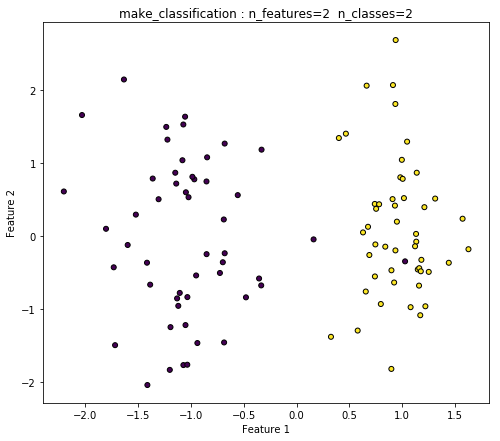

In [3]:
def get_data():
    X, Y = make_classification(
        random_state=None,
        n_features=2, 
        n_redundant=0, 
        n_informative=1,
        n_clusters_per_class=1,
        n_classes=2)
    df = pd.DataFrame(data=X)
    df['target'] = Y
    return df

df = get_data()
x = df.drop('target', axis=1)
y = df['target']
fig = plt.figure()
plt.figure(figsize=(8, 7))
plt.title("make_classification : n_features=2  n_classes=2")
plt.scatter(x.loc[:, 0], x.loc[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

## 判別機を定義

In [4]:
class Classificater():
    """
    分類機です
    """
    def __init__(self, df_train, df_label):
        self.df_train = df_train
        self.df_label = df_label
    
    @classmethod
    def init(cls, df_train, df_label):
        """
        分類機のインスタンスを生成します。
        """
        if df_train.shape[0] != df_label.shape[0]:
            print(f"df_train : {df_train.shape}")
            print(f"df_label : {df_label.shape}")
            raise Exception('データセットの次元が不正です。')
        return cls(df_train=df_train, df_label=df_label)
        
    def print_shape(self):
        """
        形状を表示します
        """
        print(f"df_train : {self.df_train.shape}")
        print(f"df_label : {self.df_label.shape}")
#         print(f"df_omega : {self.df_omega.shape}")
    
    @abstractmethod
    def fit(self):
        """
        学習を行います。
        """
        pass
    
    @abstractmethod
    def predict(self, nd_sample):
        """
        予測を行います。
        """
        pass


In [5]:
def get_grid(xlim, ylim, num):
    """
    グリッドデータを取得します
    """
    range_x = np.linspace(int(xlim[0]), int(xlim[1]), num)
    range_y = np.linspace(int(ylim[0]), int(ylim[1]), num)
    ranges = (range_x, range_y)
    nd_x = np.meshgrid(range_x, range_y)
    return ranges, np.array(nd_x).reshape(2, nd_x[0].size)

## 判別機を実装

In [6]:
class SquaresErrorClassificater(Classificater):
    """
    最小２乗法を用いた分類機です。
    """
    def __init__(self, df_train, df_label):
        super().__init__(df_train, df_label)
        self.clf = LinearRegression()
    
    def fit(self):
        nd_label = self.df_label.values
        nd_label_clean = nd_label + (nd_label-1)
        self.clf.fit(self.df_train, nd_label_clean)
    
    def predict(self, nd_sample):
        return self.clf.predict(nd_sample)
    

class FisherClassificater(Classificater):
    """
    フィッシャー法を用いた分類機です。
    """
    def __init__(self, df_train, df_label):
        super().__init__(df_train, df_label)
        
    def fit(self):
        df_train_c1 = self.df_train[self.df_label == 0]
        df_train_c2 = self.df_train[self.df_label == 1]
        mean_c1 = np.mean(df_train_c1)
        mean_c2 = np.mean(df_train_c2)
        cov_c1 = CovarianceMatrix.genarate(df_train_c1.values)
        cov_c2 = CovarianceMatrix.genarate(df_train_c2.values)
        number = df_train_c1.shape[0]  + df_train_c2.shape[0] 
        p_c1 = df_train_c1.shape[0] / number
        p_c2 = df_train_c2.shape[0] / number
        
        item =  p_c1 * cov_c1 + p_c2 * cov_c2
        nd_w = np.linalg.inv(item).dot((mean_c1 - mean_c2))
        item =  p_c1 * mean_c1 + p_c2 * mean_c2
        w_0 = self.df_train.mean(axis=1) - nd_w.T.dot(item)
        self.omega = nd_w, w_0
    
    def predict(self, nd_sample):
        if self.omega is None:
            Exception('正常に学習できていません')
        y = self.omega[0].dot(nd_sample.T) + self.omega[1]
        return y.values


class LogisticClassificater(Classificater):
    """
    ロジスティック法を用いた分類機です。
    """
    def __init__(self, df_train, df_label):
        super().__init__(df_train, df_label)
        self.clf = LogisticRegression()

    def fit(self):
        self.clf.fit(self.df_train, self.df_label)
    
    def predict(self, nd_sample):
        return self.clf.predict(nd_sample)


""" test """
df = get_data()
SquaresErrorClassificater.init(df.drop('target', axis=1), df['target']).print_shape()
FisherClassificater.init(df.drop('target', axis=1), df['target']).print_shape()
LogisticClassificater.init(df.drop('target', axis=1), df['target']).print_shape()

df_train : (100, 2)
df_label : (100,)
df_train : (100, 2)
df_label : (100,)
df_train : (100, 2)
df_label : (100,)


<Figure size 432x288 with 0 Axes>

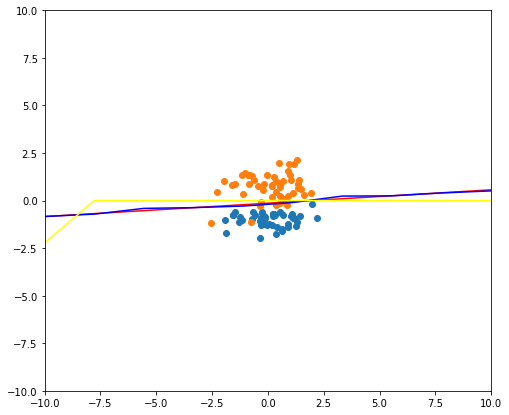

In [90]:
""" test """
df = get_data()
ranges, grid = get_grid((-10, 10), (-10, 10), 10)

model1 = SquaresErrorClassificater.init(df.drop('target', axis=1), df['target'])
model2 = FisherClassificater.init(df.drop('target', axis=1), df['target'])
model3 = LogisticClassificater.init(df.drop('target', axis=1), df['target'])

model1.fit()
result1 = model1.predict(grid.T)
model2.fit()
result2 = model2.predict(grid.T)
model3.fit()
result3 = model3.predict(grid.T)

df_c1 = df[df['target'] == 0]
df_c2 = df[df['target'] == 1]

fig = plt.figure()
plt.figure(figsize=(8, 7))
plt.scatter(df_c1.loc[:,0], df_c1.loc[:,1])
plt.scatter(df_c2.loc[:,0], df_c2.loc[:,1])
cont = plt.contour(ranges[0], ranges[1], result1.reshape(len(ranges[0]), len(ranges[1])), levels=[0], colors='red')
# cont.clabel(fmt='%1.1f', fontsize=14)
cont = plt.contour(ranges[0], ranges[1], result2.reshape(len(ranges[0]), len(ranges[1])), levels=[0], colors='blue')
# cont.clabel(fmt='%1.1f', fontsize=14)
cont = plt.contour(ranges[0], ranges[1], result3.reshape(len(ranges[0]), len(ranges[1])), levels=[0.5], colors='yellow')
# cont.clabel(fmt='%1.1f', fontsize=14)